## Negative Binomial Distribution 
Testing negative binomial distribution fits for the SFMS

probability mass function
$$P_{NB}(k; \mu, \theta) = \binom{\theta + k - 1}{\theta -1}  (\frac{\mu}{\theta + \mu})^k (\frac{\theta}{\theta+\mu})^\theta$$

In [1]:
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.misc import comb as nCk
from scipy.stats import nbinom as nbinom

In [2]:
from ChangTools.plotting import prettyplot
prettyplot()

plot $P_{NB}$ 
reproducing figure 1 in `Feldmann (2017)`

In [3]:
def NB_pdf_logx(k, mu, theta, loc=0, dk=1.): 
    ''' PDF of Negative binomial distribution 
    '''
    pdeff = np.zeros(len(k))
    big = np.where(k > 1.)
    p = theta / (theta+mu)
    cdf1 = nbinom.cdf(k[big]-dk, theta, p, loc)
    cdf2 = nbinom.cdf(k[big]+dk, theta, p, loc)
    
    pdeff[big] = (cdf2 - cdf1)/(np.log10(k[big]+dk) - np.log10(k[big]-dk))
    return pdeff


In [4]:
def zNB_pdf_logx(k, mu, theta, pi, dk=1., cutoff=0.): 
    ''' PDF of zero inflation Negative binomial distribution 
    '''
    above = np.where(cutoff < k)
    k_abv = k[above]
    p = theta / (theta+mu)
       
    pdf = np.zeros(len(k))
    pdf[above] = (1. - pi) * (
        (nbinom.cdf(k_abv + dk, theta, p) - nbinom.cdf(k_abv - dk, theta, p))/(np.log10(k_abv+dk) - np.log10(k_abv-dk)))
    
    below = np.where(k <= cutoff)
    pdf[below] = pi
    return pdf

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


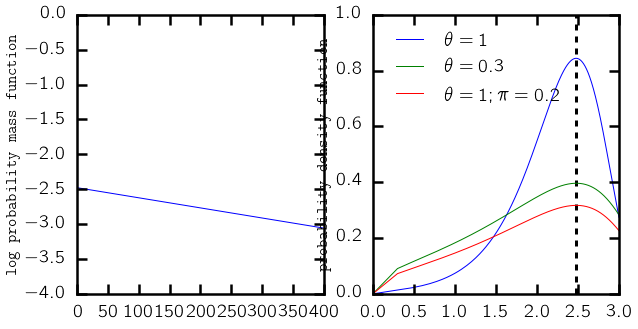

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.plot(np.arange(400), np.log10(nbinom.pmf(np.arange(400), 1, 1./301.)))
sub.set_xlim([0., 400.])
sub.set_ylim([-4., 0.])
sub.set_ylabel("log probability mass function")

sub = fig.add_subplot(132)
logx = np.log10(np.arange(1000))
sub.plot(logx, NB_pdf_logx(np.arange(1000), 300., 1.), label=r"$\theta = 1$")
sub.plot(logx, NB_pdf_logx(np.arange(1000), 300., 0.3), label=r"$\theta = 0.3$")
sub.plot(logx, zNB_pdf_logx(np.arange(1000), 300., 0.3, 0.2), c= 'r', label=r"$\theta=1;\/ \pi = 0.2$")
sub.vlines(np.log10(300), 0., 1., color='k', lw=3, linestyle='--')
sub.set_xlim([0, 3])
sub.set_ylabel("probability density function")
sub.legend(loc='upper left')
plt.show()

Now lets import SFRs from catalogs and fit it

In [7]:
import catalogs as Cat
import util as UT

In [8]:
cata = Cat.Catalog() # catalog class
logM, logSFR, w = cata.Read('illustris1') # lets test out Jeremy's group catalog 

25729  of  54356  galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.


catalogs.py:51: RuntimeWarning: divide by zero encountered in log10
  logSFR = np.log10(ill_ssfr1) + ill_logMstar
catalogs.py:51: RuntimeWarning: invalid value encountered in log10
  logSFR = np.log10(ill_ssfr1) + ill_logMstar


### P(log sSFR) of Illustris for mass bin $9.5 < log \, M_* < 10$

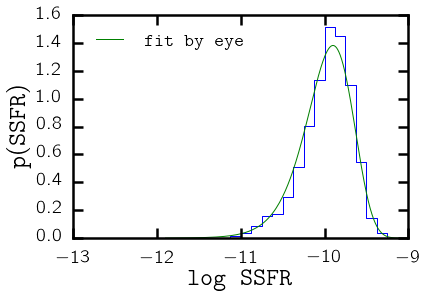

In [10]:
fig = plt.figure()
sub = fig.add_subplot(111)
in_mbin = np.where((logM > 9.5) & (logM <= 10.))

p_ssfr, bin_ssfr = np.histogram(logSFR[in_mbin] - logM[in_mbin], bins=40, range=[-13,-8], normed=True)
x_ssfr, y_ssfr = UT.bar_plot(bin_ssfr, p_ssfr)
sub.plot(x_ssfr, y_ssfr)
# fit by eye
sub.plot(logx-11.9, NB_pdf_logx(np.arange(1000), 100., 2.5), label="fit by eye")
sub.set_xlim([-13, -9])
sub.set_xticks([-13, -12, -11, -10, -9])
sub.set_xlabel('$\mathtt{log\;\; SSFR}$', fontsize=25)
sub.set_ylabel('$\mathtt{p(SSFR)}$', fontsize=25)
sub.legend(loc='upper left')

In [11]:
# parameterization of negative binomial for fitting
nb_fit = lambda x, a, mu, theta: NB_pdf_logx(np.power(10., x+a), mu, theta)

In [12]:
from scipy.optimize import curve_fit

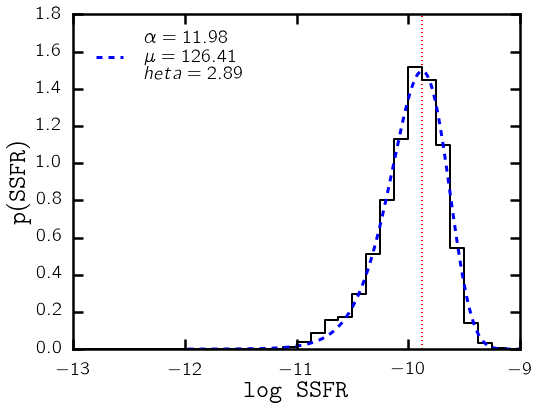

In [13]:
p_ssfr, bin_ssfr = np.histogram(logSFR[in_mbin] - logM[in_mbin], bins=40, range=[-13,-8], normed=True)

popt, pcov = curve_fit(nb_fit, 0.5*(bin_ssfr[:-1]+bin_ssfr[1:]), p_ssfr, p0=[12., 100., 1.5])#, bounds=(-13, -9))

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
in_mbin = np.where((logM > 9.5) & (logM <= 10.))

p_ssfr, bin_ssfr = np.histogram(logSFR[in_mbin] - logM[in_mbin], bins=40, range=[-13,-8], normed=True)
x_ssfr, y_ssfr = UT.bar_plot(bin_ssfr, p_ssfr)
sub.plot(x_ssfr, y_ssfr, c='k', lw=2)

# best-fit negative binomial 
lbl = ''.join([r"$\alpha = ", str(round(popt[0],2)), "$\n $\mu = ", str(round(popt[1],2)), "$\n $ \theta = ", str(round(popt[2],2)), "$"])
sub.plot(logx-popt[0], NB_pdf_logx(np.arange(1000), popt[1], popt[2]), label=lbl, c='b', lw=3, ls='--')
sub.vlines(np.log10(popt[1]) - popt[0], 0, 1.8, color='r', linewidth=2, linestyle=':')
sub.set_xlim([-13, -9])
sub.set_xticks([-13, -12, -11, -10, -9])
sub.set_xlabel('$\mathtt{log\;\; SSFR}$', fontsize=25)
sub.set_ylabel('$\mathtt{p(SSFR)}$', fontsize=25)
sub.legend(loc='upper left')